In [1]:
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
import torch

REPO_PATH = "/users/gabrijel/projects/vfmf/" # adjust this
CKPTS_PATH = "/work/gabrijel/vfmf-checkpoints" # adjust this

## Configuration

In [2]:
CONFIG_PATH =  f"{REPO_PATH}/world-model/configs/kubric"
CONFIG_NAME = "dino_foresight_cfm_3x_wandb_latent_variable_length.yaml"
CKPT_PATH = f"{CKPTS_PATH}/world-model/kubric/vae/raw_convnext_isotropic_base(VAE, beta=0.01)/epoch=2399.pt"

WEIGHTS = "ema"
BETA = "0.01"
DEVICE = torch.device("cuda:0")

RGB_DECODER_CONFIG=f"{REPO_PATH}/vae/configs"
RGB_DECODER_NAME="default_raw_movi_a_rgb_vae"
RGB_DECODER_CKPT=f"{CKPTS_PATH}/rgb/kubric/dino_foresight_vit_base_rgb_decoder(vae)/best.pt"

SEG_CKPT=f"{CKPTS_PATH}/heads/kubric/train_kubric_vae_224_l[2,_5,_8,_11]_fgbg_seg_head_batch_size=128_lr=1e-5/lightning_logs/version_0/checkpoints/epoch=43-step=80080.ckpt"
DEPTH_CKPT=f"{CKPTS_PATH}/heads/kubric/train_kubric_vae_224_l[2,_5,_8,_11]_depth_head_batch_size=128_lr=1e-5/lightning_logs/version_0/checkpoints/epoch=1-step=3640.ckpt"
NORMALS_CKPT=f"{CKPTS_PATH}/heads/kubric/train_kubric_vae_224_l[2,_5,_8,_11]_normals_head_batch_size=128_lr=1e-5/lightning_logs/version_0/checkpoints/epoch=99-step=182000.ckpt"


# seeds = [0,1,7,17,42]
seeds = [0,1,7]

horizon = 24
sampling_steps = 10
sampling_method = "euler"
context_length = 2 # adjust this, valid values are: 1, 2, 3, 4

config_name_no_ext = CONFIG_NAME

with initialize_config_dir(config_dir=CONFIG_PATH, version_base=None):
  cfg = compose(
      config_name=config_name_no_ext,
      overrides=[
          f"vae.model.beta={BETA}",
      ],
  )
  cfg.vae.ckpt_path = f"{CKPTS_PATH}/vae/kubric/{cfg.vae.name}/checkpoints/best.pt" 
  cfg.vae.latent_dist_stats_path = f"{CKPTS_PATH}/feature_stats/kubric/movi_a/{cfg.vae.name}.npz"
  cfg.vae.model.feature_stats = f"{CKPTS_PATH}/feature_stats/kubric/movi_a/dino.npz" 
  
print(OmegaConf.to_yaml(cfg))

model:
  sequence_length: 5
  img_size:
  - 224
  - 224
  patch_size: 14
  separable_attention: true
  separable_window_size: 1
  layers: 12
  heads: 8
  hidden_dim: 1152
  dropout: 0.1
vae:
  objective: VAE
  name: ${vae.model.name}(${vae.objective}, beta=${vae.model.beta})
  model:
    name: raw_convnext_isotropic_base
    dinov2_variant: vitb14_reg
    feature_stats: /work/gabrijel/vfmf-checkpoints/feature_stats/kubric/movi_a/dino.npz
    intermediate_layers:
    - 2
    - 5
    - 8
    - 11
    patch_size: 14
    input_dim: 3072
    depth: 18
    dim: 768
    latent_channels: 16
    drop_path_rate: 0
    layer_scale_init_value: 0
    shape:
    - 16
    - 16
    beta: 0.01
  ckpt_path: /work/gabrijel/vfmf-checkpoints/vae/kubric/raw_convnext_isotropic_base(VAE,
    beta=0.01)/checkpoints/best.pt
  latent_dist_stats_path: /work/gabrijel/vfmf-checkpoints/feature_stats/kubric/movi_a/raw_convnext_isotropic_base(VAE,
    beta=0.01).npz
training:
  wandb: true
  seed: 123
  epochs: 2400
 

In [3]:
# vae:
#   objective: VAE
#   name: ${vae.model.name}(${vae.objective}, beta=${vae.model.beta})
#   model:
#     name: raw_convnext_isotropic_base
#     dinov2_variant: vitb14_reg
#     feature_stats: /users/gabrijel/projects/vgg-wm-vae/feature_stats/kubric/movi_a/dino.npz
#     intermediate_layers:
#     - 2
#     - 5
#     - 8
#     - 11
#     patch_size: 14
#     input_dim: 3072
#     depth: 18
#     dim: 768
#     latent_channels: 16
#     drop_path_rate: 0
#     layer_scale_init_value: 0
#     shape:
#     - 16
#     - 16
#     beta: 0.01
#   ckpt_path: /work/gabrijel/vfmf-checkpoints/vae/kubric/${vae.name}/checkpoints/best.pt
#   latent_dist_stats_path: /work/gabrijel/vfmf-checkpoints/feature_stats/kubric/movi_a/${vae.name}.npz

## Load the pipeline

In [4]:
from typing import Literal
from omegaconf import DictConfig
from torchinfo import summary

def load_denoiser(
  cfg: DictConfig,
  ckpt_path: str,
  weights: Literal["model", "ema"] = "ema",
  device: torch.device = torch.device("cpu")
):
  from models.autoregressive_dino_foresight_latent import AutoregressiveDINOForesightLatent

  denoiser = AutoregressiveDINOForesightLatent(**cfg.model, vae=cfg.vae)
  ckpt = torch.load(
      ckpt_path,
      map_location="cpu",
      weights_only=False
  )
  denoiser.load_state_dict(ckpt[f"{weights}_state_dict"])
  denoiser = denoiser.to(device)
  denoiser.eval()

  return denoiser

def load_rgb_decoder(
    decoder_config_dir: str,
    decoder_config_name: str,
    decoder_ckpt: str,
    device: torch.device
):
  from models.dino_rgb_decoder import DINORGBDecoder

  initialize_config_dir(
    config_dir=decoder_config_dir,
    version_base=None
  )
  cfg = compose(config_name=decoder_config_name)
  rgb_decoder = DINORGBDecoder(**cfg.model)
  ckpt = torch.load(
    decoder_ckpt,
    map_location=device
  )
  rgb_decoder.load_state_dict(ckpt["model_state_dict"])
  rgb_decoder = rgb_decoder.to(device)
  _ = rgb_decoder.eval()

  return rgb_decoder

In [5]:
denoiser = load_denoiser(cfg, CKPT_PATH, WEIGHTS, DEVICE)
summary(denoiser)

/users/gabrijel/miniconda3/envs/dino_foresight/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in /users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main
/users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


Layer (type:depth-idx)                                  Param #
AutoregressiveDINOForesightLatent                       --
├─DINORawVAE: 1-1                                       --
│    └─DinoVisionTransformer: 2-1                       1,056,768
│    │    └─PatchEmbed: 3-1                             (452,352)
│    │    └─ModuleList: 3-2                             (85,072,896)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Identity: 3-4                               --
│    └─ConvNeXtIsotropicVAE: 2-2                        --
│    │    └─ConvNeXtIsotropic: 3-5                      (88,082,688)
│    │    └─LayerNorm: 3-6                              (1,536)
│    │    └─Linear: 3-7                                 (24,608)
│    │    └─Linear: 3-8                                 (13,056)
│    │    └─ConvNeXtIsotropic: 3-9                      (86,313,216)
│    │    └─Linear: 3-10                                (2,362,368)
├─MaskTransformer: 1-2             

In [6]:
rgb_decoder = load_rgb_decoder(
  RGB_DECODER_CONFIG,
  RGB_DECODER_NAME,
  RGB_DECODER_CKPT,
  DEVICE
)
summary(rgb_decoder)

Using cache found in /users/gabrijel/.cache/torch/hub/facebookresearch_dinov2_main


Layer (type:depth-idx)                             Param #
DINORGBDecoder                                     --
├─DinoVisionTransformer: 1-1                       1,056,768
│    └─PatchEmbed: 2-1                             --
│    │    └─Conv2d: 3-1                            (452,352)
│    │    └─Identity: 3-2                          --
│    └─ModuleList: 2-2                             --
│    │    └─NestedTensorBlock: 3-3                 (7,089,408)
│    │    └─NestedTensorBlock: 3-4                 (7,089,408)
│    │    └─NestedTensorBlock: 3-5                 (7,089,408)
│    │    └─NestedTensorBlock: 3-6                 (7,089,408)
│    │    └─NestedTensorBlock: 3-7                 (7,089,408)
│    │    └─NestedTensorBlock: 3-8                 (7,089,408)
│    │    └─NestedTensorBlock: 3-9                 (7,089,408)
│    │    └─NestedTensorBlock: 3-10                (7,089,408)
│    │    └─NestedTensorBlock: 3-11                (7,089,408)
│    │    └─NestedTensorBlock: 3-12 

In [7]:
from decoder import ModalitiesDecoder

modalities_decoder = ModalitiesDecoder(
    fg_bg_ckpt={},
    segm_ckpt=SEG_CKPT,
    depth_ckpt=DEPTH_CKPT,
    normals_ckpt=NORMALS_CKPT,
    image_size=(224, 224),
    resize_size=(256, 256),
    embed_dim=768,
    dpt_num_features=256,
    dpt_use_bn=True,
    dpt_out_channels=[128, 256, 512, 512],
    dpt_use_clstoken=False,
    dpt_layers=[2, 5, 8, 11],
    num_segm_classes=2
)
modalities_decoder = modalities_decoder.to(DEVICE)
summary(modalities_decoder)

Layer (type:depth-idx)                                  Param #
ModalitiesDecoder                                       --
├─ModalityDecoder: 1-1                                  --
│    └─DPTHead: 2-1                                     --
│    │    └─ModuleList: 3-1                             1,082,752
│    │    └─ModuleList: 3-2                             2,884,480
│    │    └─Module: 3-3                                 13,547,522
├─ModalityDecoder: 1-2                                  --
│    └─DPTHead: 2-2                                     --
│    │    └─ModuleList: 3-4                             1,082,752
│    │    └─ModuleList: 3-5                             2,884,480
│    │    └─Module: 3-6                                 13,612,800
├─ModalityDecoder: 1-3                                  --
│    └─DPTHead: 2-3                                     --
│    │    └─ModuleList: 3-7                             1,082,752
│    │    └─ModuleList: 3-8                             2,8

## Sampling

In [8]:

from typing import List
from models.autoregressive_dino_foresight_latent import AutoregressiveDINOForesightLatent
from sample_benchmark import sample_autoregressive
from seed import seed_everything
from tqdm.auto import tqdm

def sample(
  denoiser: AutoregressiveDINOForesightLatent,
  rgb_ctx: torch.Tensor,
  seeds: List[int],
  sampling_steps: int,
  sampling_method: str,
  device: torch.device
) -> List[torch.Tensor]:
  _, context_length, *_ = rgb_ctx.shape
  
  f_preds: List[torch.Tensor] = []
  f_ctx: torch.Tensor = denoiser.vae.postprocess(
    denoiser.vae.preprocess(rgb_ctx)
  )

  for seed in tqdm(seeds):
    seed_everything(seed)

    if "cityscapes" in cfg.data.dataset_root:
      num_rollouts = 9 - (context_length - 1)
    else:
      num_rollouts = 11 - (context_length - 1)

    max_context_length = 4
    f_pred = sample_autoregressive(
        denoiser,
        f_ctx,
        num_rollouts,
        max_context_length,
        sampling_steps,
        sampling_method,
        rng=torch.Generator(device).manual_seed(seed)
    )
    f_preds.append(f_pred)

  return f_preds

## Dataset

In [9]:
from datasets.kubric import KubricMultiDataset

dataset = KubricMultiDataset(
  dataset_root=f"{REPO_PATH}/world-model/demos/kubric",
  context_length=context_length # adjust context length
)

Preview demo examples.

In [10]:
from PIL import Image
from einops import rearrange

from transforms import denormalize_dino


context_rgbs = [
    [
        Image.fromarray(rearrange(x.numpy(), "c h w -> h w c"))
        for x in (
            (denormalize_dino()(dataset[index]["context_rgb"]) * 255).to(torch.uint8)
        )[:context_length] # chunk by context_len
    ]
    for index in range(len(dataset))
]


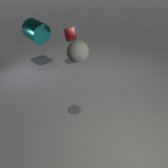
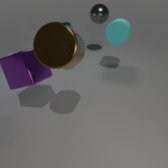
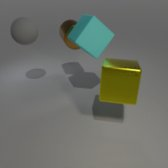
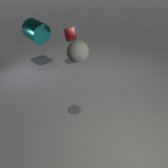
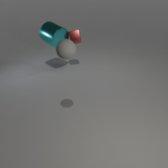
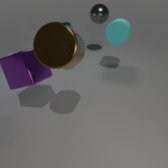
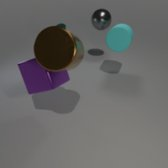
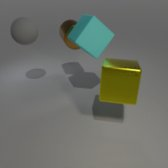
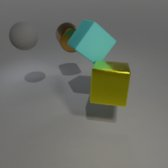

In [11]:
from notebook_utils import display_context_animations


display_context_animations(
  [
      [
          Image.fromarray(rearrange(x.numpy(), "c h w -> h w c"))
          for x in (
              (denormalize_dino()(dataset[index]["context_rgb"]) * 255).to(torch.uint8)
          )[:context_length] # chunk by context_len
      ]
      for index in range(len(dataset))
  ],
  max_frames=4,
  fps=6,
  scale=0.75
)


In [12]:
dataset_index = 2 # adjust it here

In [13]:
context_rgbs = dataset[dataset_index]['context_rgb'][None]
context_segm = dataset[dataset_index]['context_segm'][None]
context_depth = dataset[dataset_index]['context_depth'][None]
context_normals = dataset[dataset_index]['context_surface_normals'][None]

In [14]:
rgb_ctx = context_rgbs.to(DEVICE)

f_preds = sample(
  denoiser,
  rgb_ctx,
  seeds,
  sampling_steps,
  sampling_method,
  DEVICE
)

  0%|          | 0/3 [00:00<?, ?it/s]

[sampling steps]: 10
[context length]: 2
[context length]: 3
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[sampling steps]: 10
[context length]: 2
[context length]: 3
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[sampling steps]: 10
[context length]: 2
[context length]: 3
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4
[context length]: 4


## Samples

Decode features.

In [15]:
from PIL import Image
from einops import rearrange

from transforms import denormalize_dino
from visualization import decode_rgb, depth_to_image, normals_to_image, segs_to_image

example_idx = 0

sample_segs: List[List[Image.Image]] = []
sample_depths: List[List[Image.Image]]  = []
sample_normals: List[List[Image.Image]]  = []
sample_rgbs: List[List[Image.Image]]  = []

context_rgbs = [
  Image.fromarray(
    rearrange(
      x.numpy(),
      "c h w -> h w c"
    )
  )
  for x in (
    (denormalize_dino()(context_rgbs) * 255)
    .to(torch.uint8)
  )[0]
]
context_segm = [
  segs_to_image(segm[0], colormap_name="bw")
  for segm in context_segm[0]
]
context_depth = [
  depth_to_image(depth[0])
  for depth in context_depth[0]
]
context_normals =  [
  normals_to_image(normals)
  for normals in context_normals[0]
]


for f_pred in f_preds:
  out = modalities_decoder(f_pred)

  segs: List[Image.Image] = []
  depths: List[Image.Image] = []
  normals: List[Image.Image] = []
  rgbs: List[Image.Image] = []

  for segm in out['segm']['labels'][example_idx]:
    segs.append(segs_to_image(segm, colormap_name="bw"))
  for depth in out['depth']['labels'][example_idx]:
    depths.append(depth_to_image(depth))
  for norm in out['surface_normals']['preds'][example_idx]:
    normals.append(normals_to_image(norm))

  sample_segs.append(segs)
  sample_depths.append(depths)
  sample_normals.append(normals)
  sample_rgbs.append(
    decode_rgb(
      rgb_decoder,
      rearrange(f_pred, "b t h w c -> t b h w c"),
      DEVICE
    )
  )

Display decoded modalities.


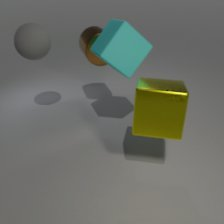
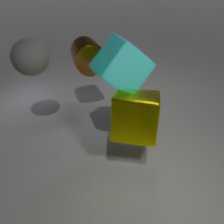
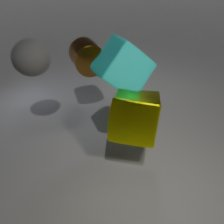
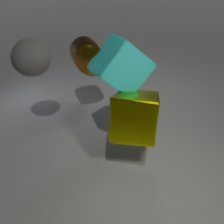
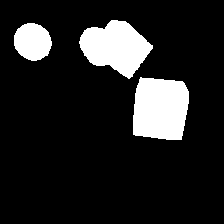
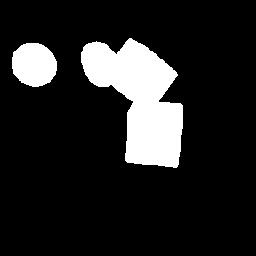
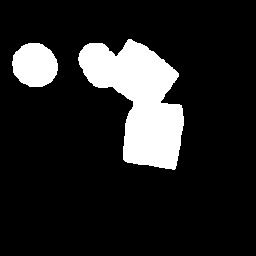
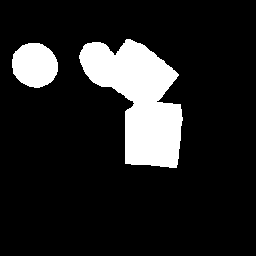
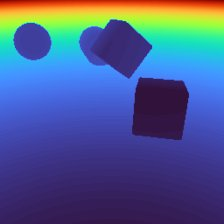
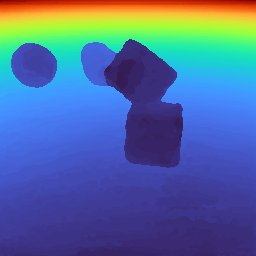
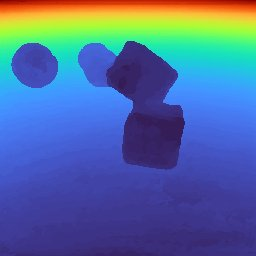
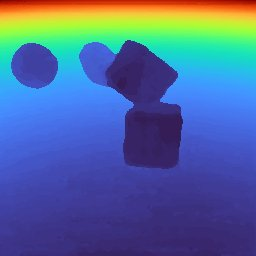
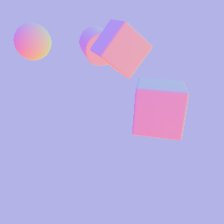
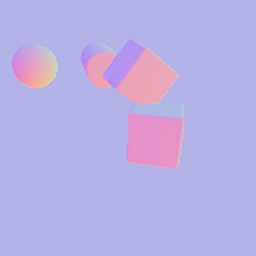
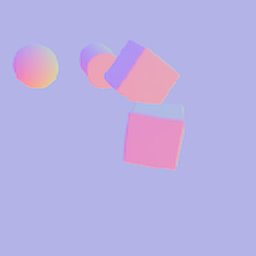
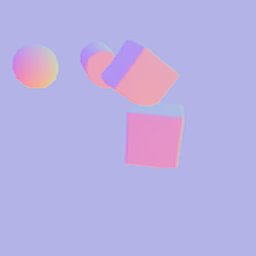
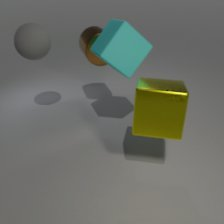
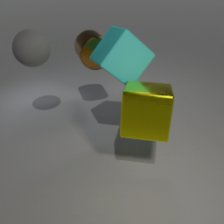
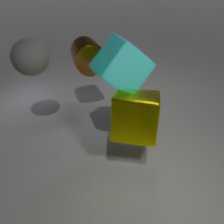
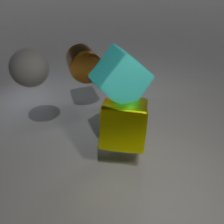
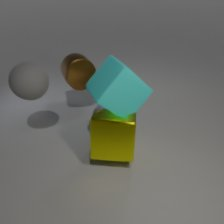
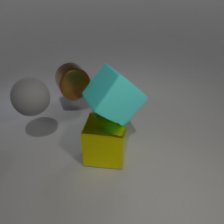
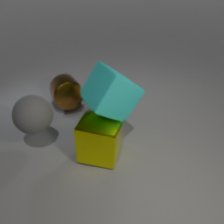
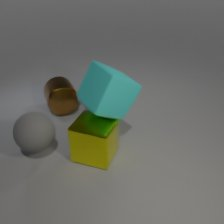
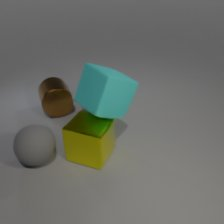
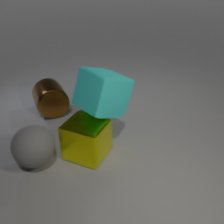
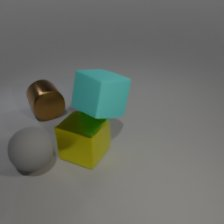
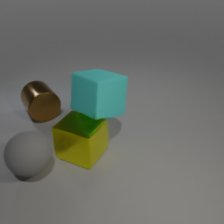
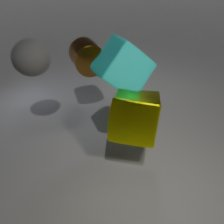
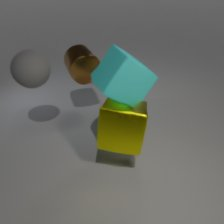
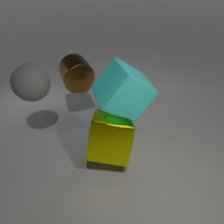
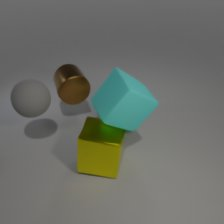
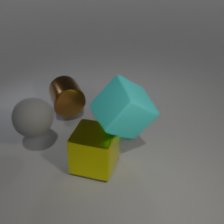
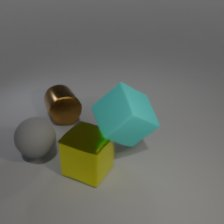
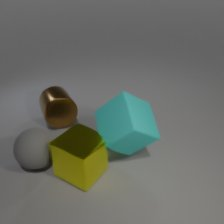
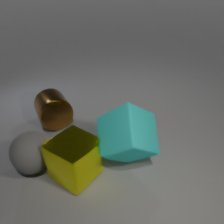
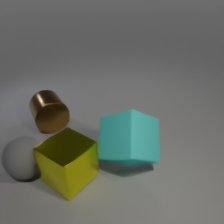
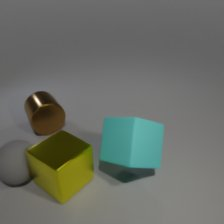
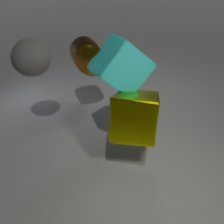
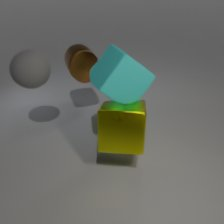
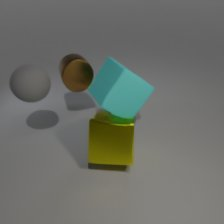
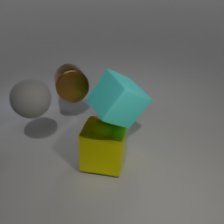
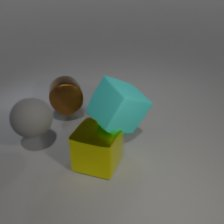
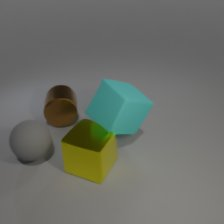
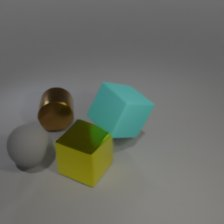
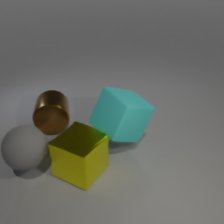
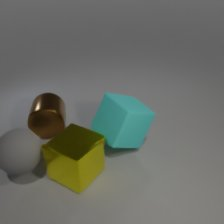
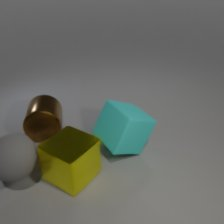
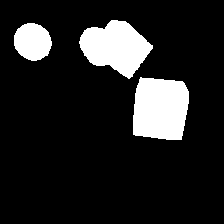
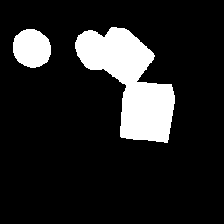
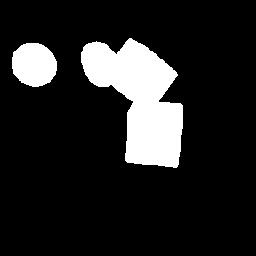
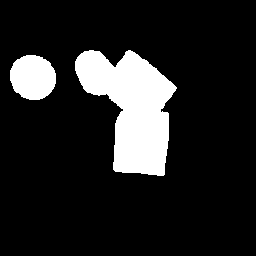
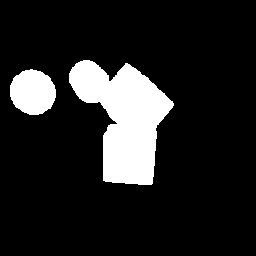
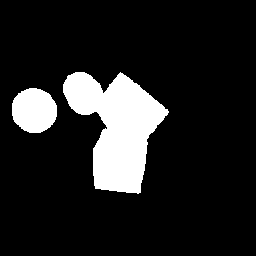
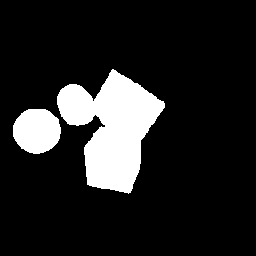
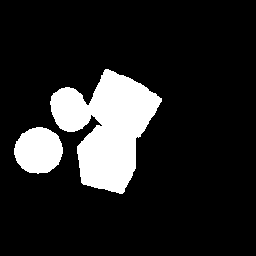
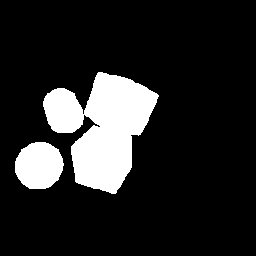
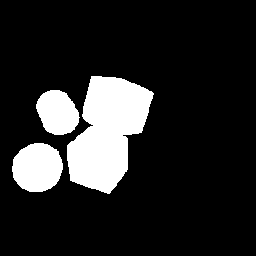
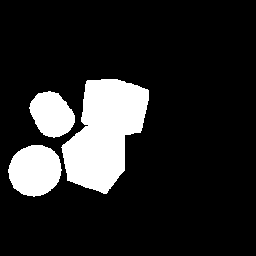
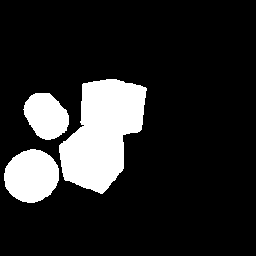
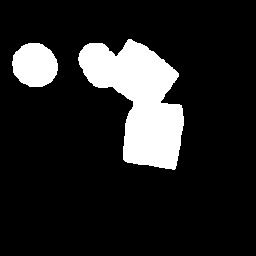
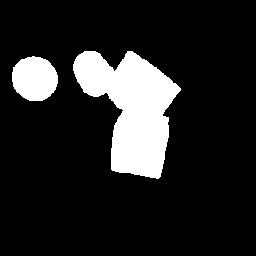
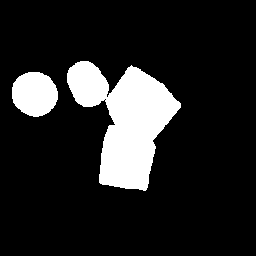
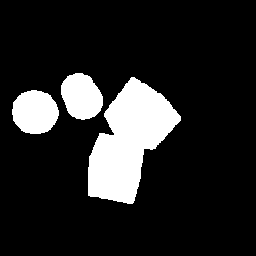
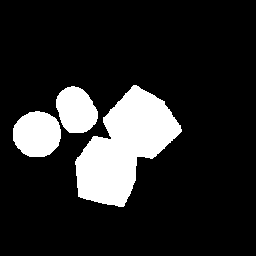
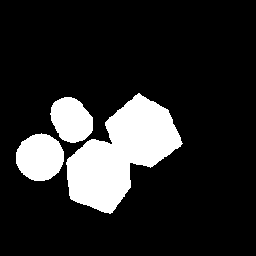
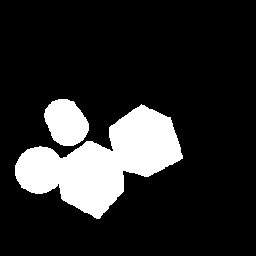
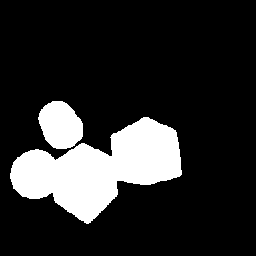
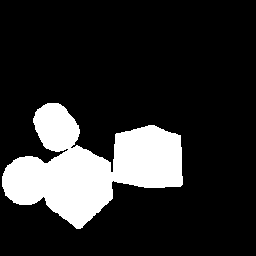
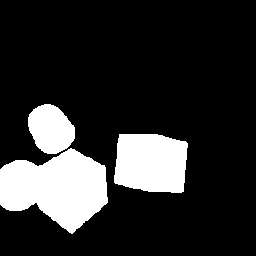
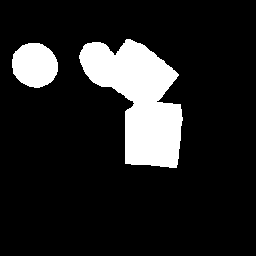
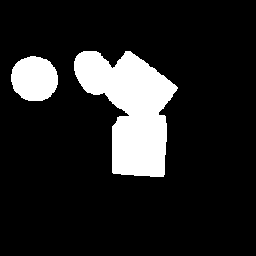
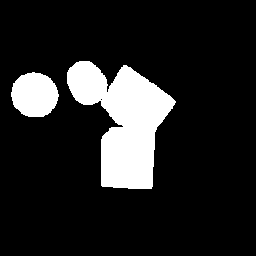
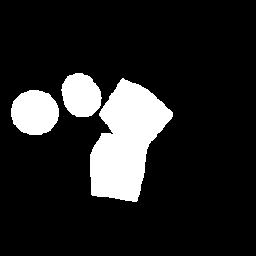
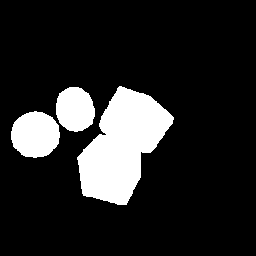
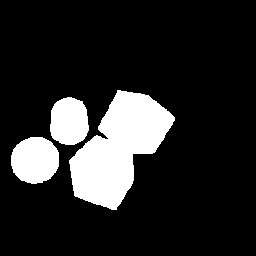
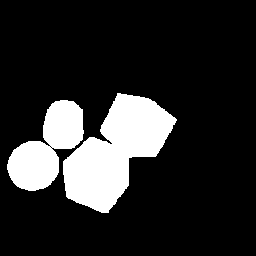
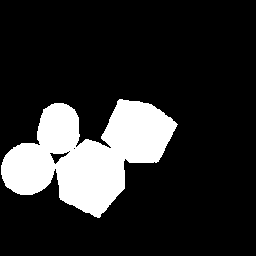
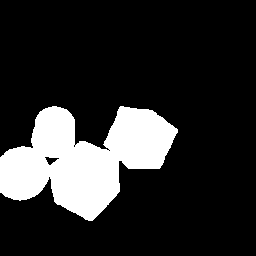
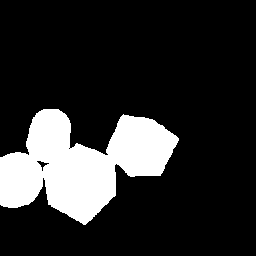
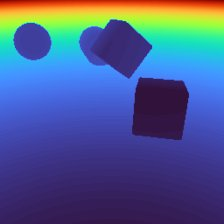
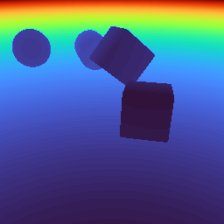
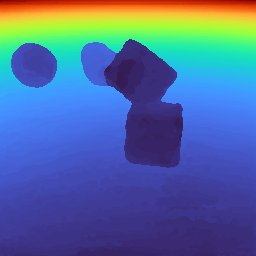
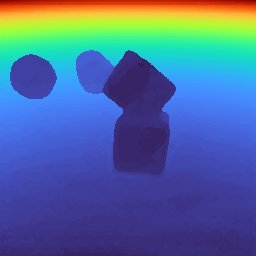
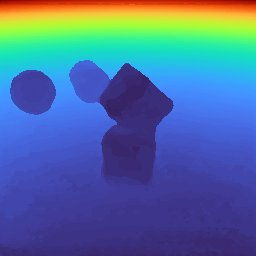
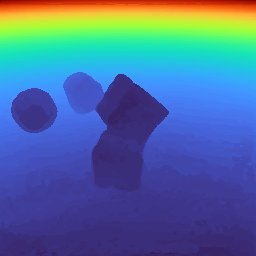
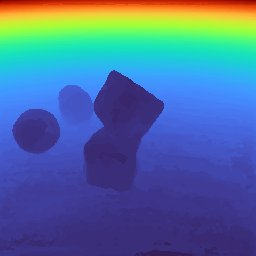
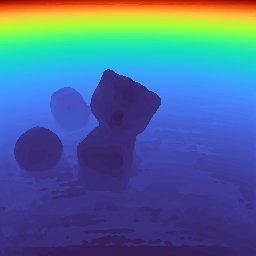
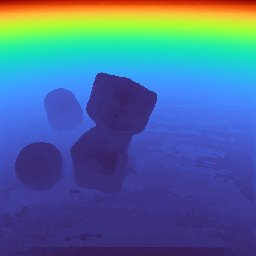
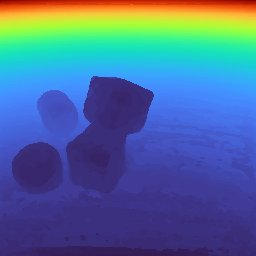
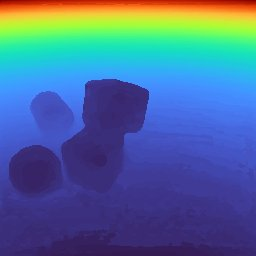
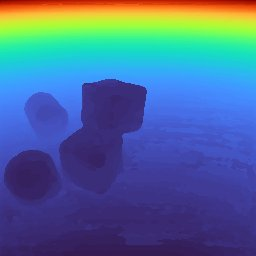
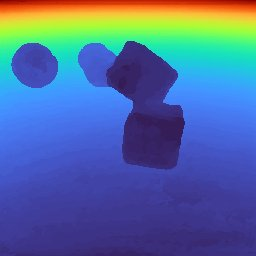
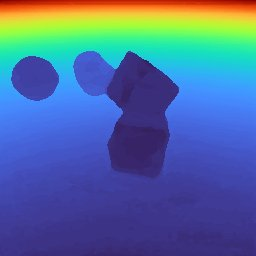
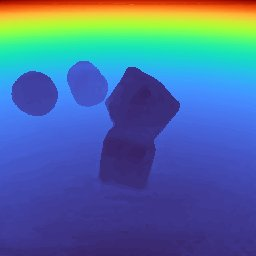
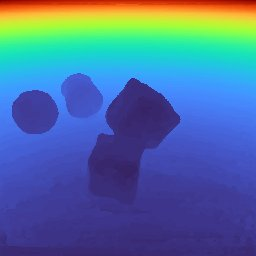
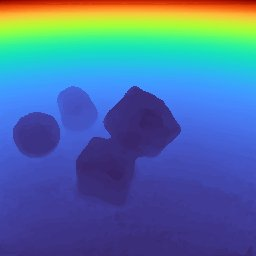
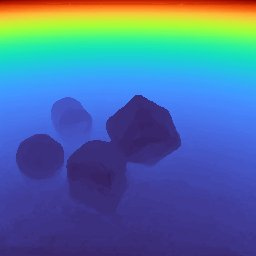
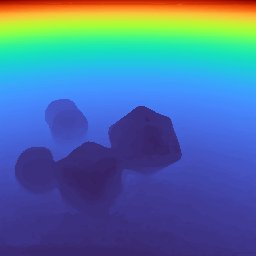
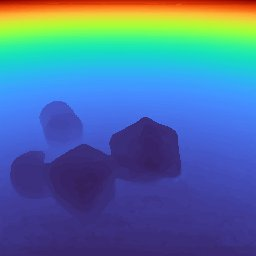
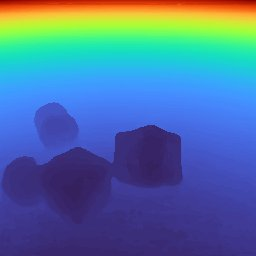
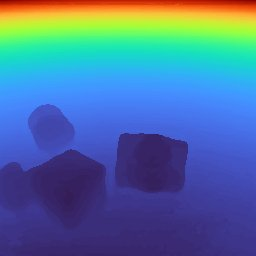
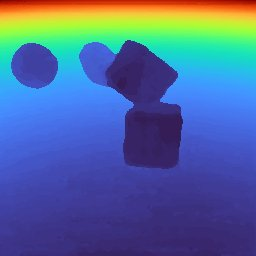
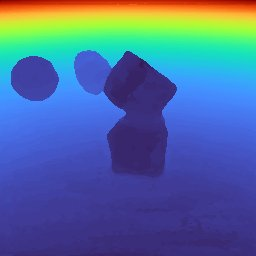
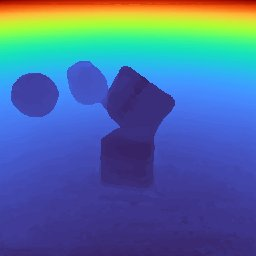
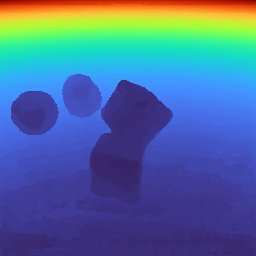
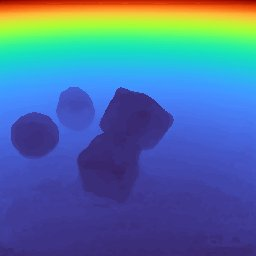
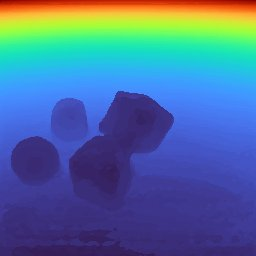
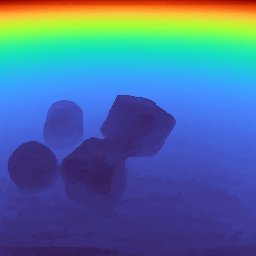
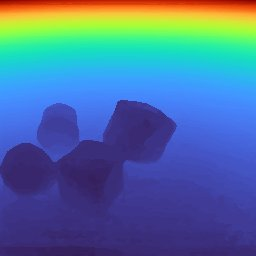
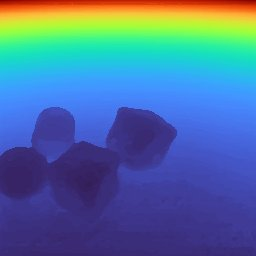
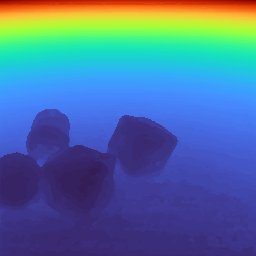
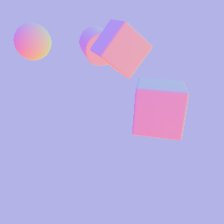
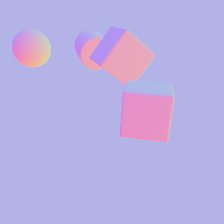
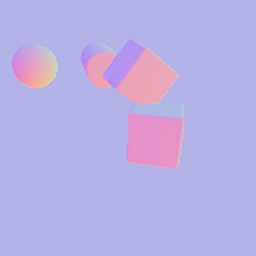
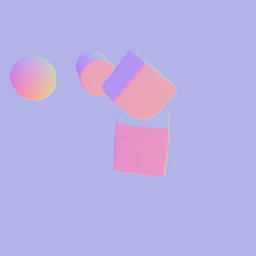
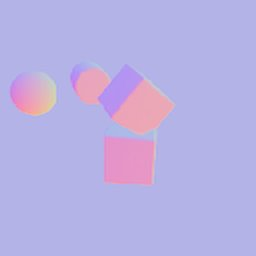
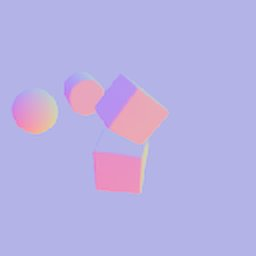
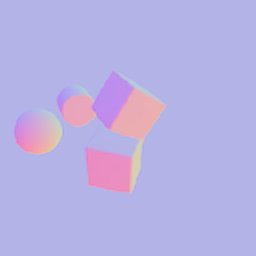
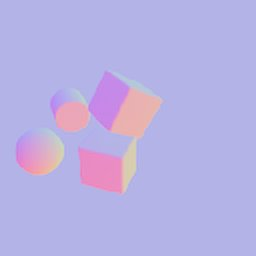
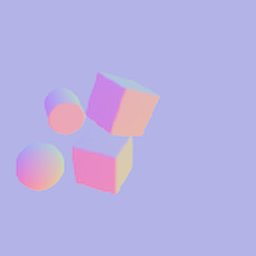
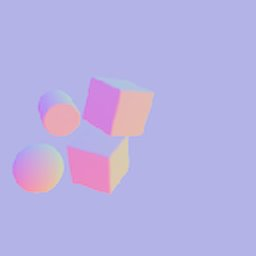
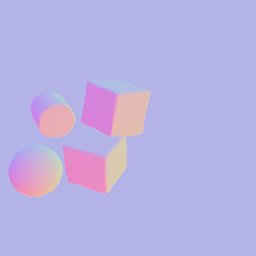
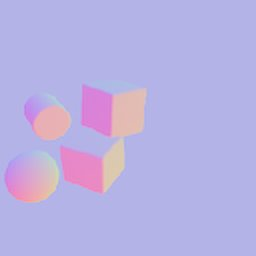
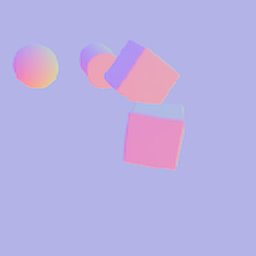
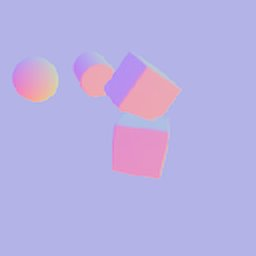
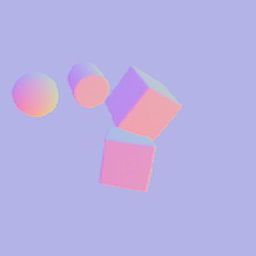
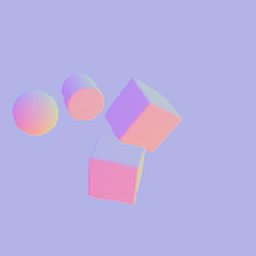
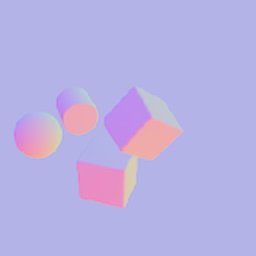
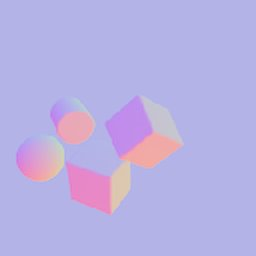
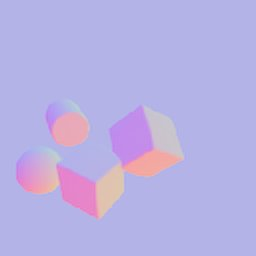
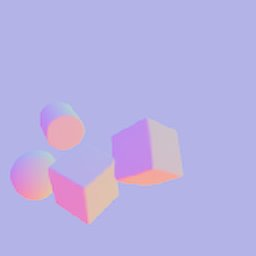
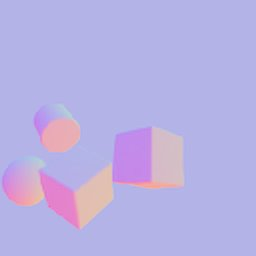
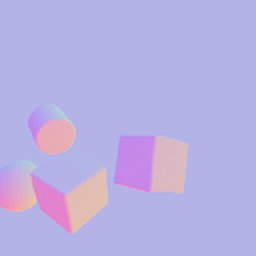
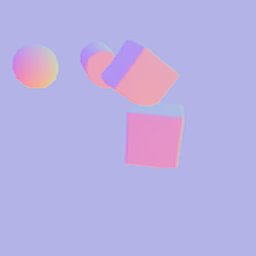
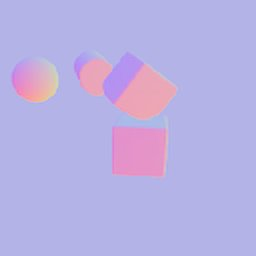
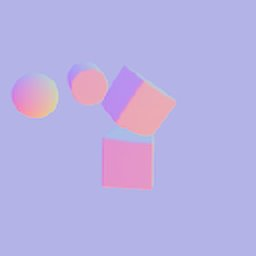
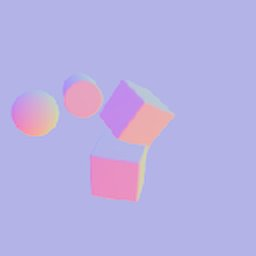
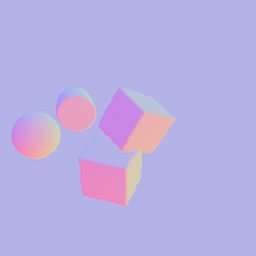
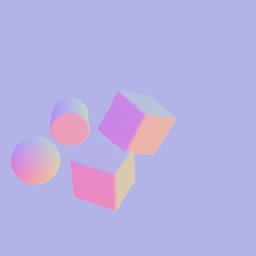
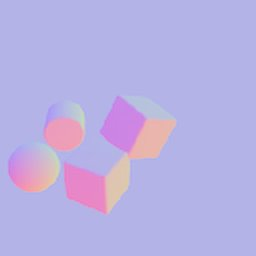
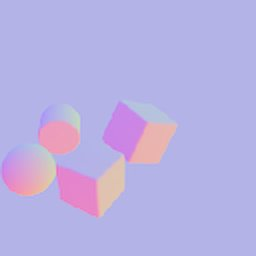
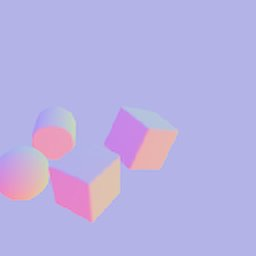
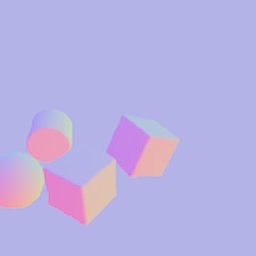

In [16]:
from notebook_utils import display_controllable_grid


display_controllable_grid(
    seeds=seeds, 
    sample_rgbs=sample_rgbs, 
    sample_segs=sample_segs, 
    sample_depths=sample_depths, 
    sample_normals=sample_normals,
    context_rgbs=context_rgbs,
    context_segs=context_segm,
    context_depths=context_depth,
    context_normals=context_normals,
    base_duration=83 # 83ms is approx 12 FPS (1000/12 = 83.33)
)
